# Credit Card Fraud Detection using Random Forest

## Exploratory Data Analysis on Credit Card Fraud Dataset

The dataset contains credit card transactions over 2 days by European cardholders. Almost all predictors (features) have been anonymized for obvious reasons. There is a need to understand the data before it can be worked upon.



### 1. Import Data

In [0]:
# author: Shamli Singh

In [1]:
# import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# store dataset to pandas dataframe
path = "/content/drive/My Drive/CS 271/Project/Data/creditcardfraud/creditcard.csv"
data = pd.read_csv(path)

In [4]:
# get to know the data
data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
253472,156268.0,0.231856,0.695912,-0.688882,-0.785320,1.280111,-0.221894,1.284531,-0.127088,-0.339893,-0.582055,0.141597,0.702260,-0.052473,0.463116,-1.396182,-0.392908,-0.691062,0.175911,0.501771,-0.115243,0.090533,0.329190,-0.205259,0.215138,0.220058,-0.316000,-0.011560,-0.020776,29.99,0
242156,151368.0,-6.351294,-3.040894,-4.292993,0.728143,-5.437818,4.549467,4.815985,-1.072058,1.834149,1.386269,1.362192,0.586793,0.923445,-0.748860,1.910356,0.906710,-0.543174,-0.804471,-0.076504,-4.473773,-0.972689,1.253647,-1.107731,-1.256100,-1.197770,0.529113,-2.533043,0.643679,1029.48,0
240398,150588.0,1.896590,-0.353569,-1.091675,0.495464,-0.272452,-0.458020,-0.422587,0.042800,1.137595,-0.467210,-0.830003,-0.557457,-1.079108,-1.013650,0.822498,0.935233,0.376956,0.301477,-0.171183,-0.078077,-0.319315,-1.038153,0.389603,0.425583,-0.638696,0.092928,-0.040877,-0.002638,69.05,0
80128,58347.0,-0.674524,-0.389697,1.207910,-1.474302,0.020176,-1.274835,1.244698,-0.817860,0.796046,-0.752953,0.132999,0.495056,0.827905,-0.311911,1.836500,-0.990095,-0.197717,-0.063004,1.537576,0.262594,-0.028613,0.426408,0.227820,0.463189,-0.377577,-0.076221,-0.249203,-0.274188,124.49,0
139448,83161.0,1.276292,0.109805,0.349824,0.631986,-0.127214,-0.136002,-0.043942,-0.112798,0.402348,-0.245481,-1.191291,0.867311,1.347258,-0.410080,-0.211246,0.001766,-0.377627,-0.600886,0.527993,-0.005345,-0.337823,-0.748705,-0.044079,-0.392447,0.489486,0.227925,-0.009032,0.011893,9.99,0


In [5]:
print(data.shape)

(284807, 31)


In [6]:
print(data.describe())

                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


### 2. Verify the imbalance

In [7]:
frauds = data[data['Class'] == 1]
valids = data[data['Class'] == 0]
fraction = len(frauds) / float(len(valids))
print("Fraud cases are {}% of total {} cases".format(fraction*100, len(frauds)+len(valids)))
print("Fraud cases = {}, Valid transactions = {}".format(len(frauds), len(valids)))

Fraud cases are 0.17304750013189596% of total 284807 cases
Fraud cases = 492, Valid transactions = 284315


### 3. Learn about the data


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# check if any variables are missing data
data.isnull().any().any()

False

In [10]:
# check amounts of valid/invalid transactions
valids.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

The average transaction is around USD 88.29, while the maximum transaction is of USD 25,691.16. It is important to check the distribution of the transactions. At this time, we can assume that the odd larger transactions could be fraudulent.

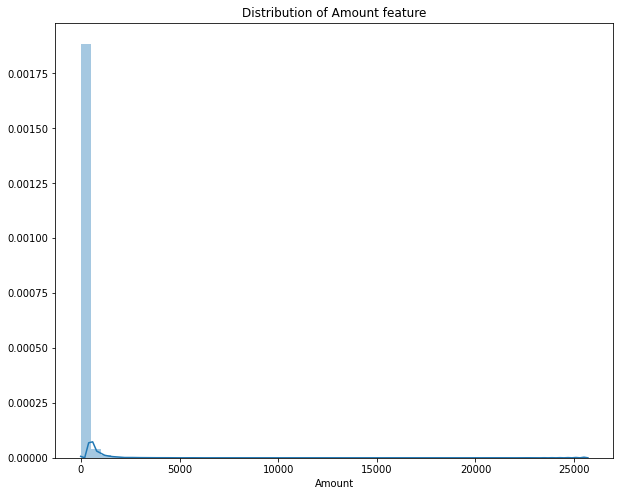

In [11]:
# check the distribution of amount feature
plt.figure(figsize=(10, 8))
plt.title('Distribution of Amount feature')
sns.distplot(data.Amount)

As visible in the plot, the distribution is heavily right-skewed, meaning we can definitely assume that the maximum genuine transactions have low amount.

### 4. Correlation matrix
Correlation matrix gives a graphical idea of how features are correlate with each other. It can be visualized as a heatmap that can help us deciding which features will be most relevant for prediction.

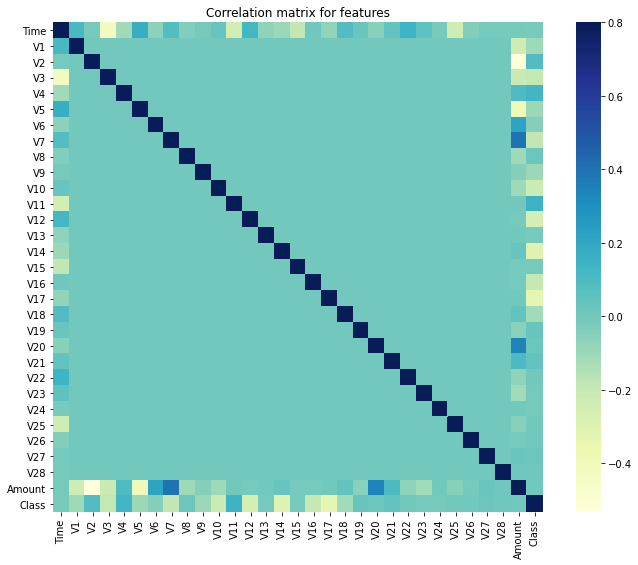

In [12]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 9))
plt.title('Correlation matrix for features')
# plot the matrix as a heatmap
sns.heatmap(corr_matrix, vmax=0.8, cmap='YlGnBu', square=True)
plt.show()

We see that the strongest color is seen along the diagonal, which means the features are highly correlated with themselves; this is an ideal case. Most of the features do not correlate to each other. Some features do have either positive or negative correlations. e.g. features *V2*, *V5*, *V1* and *V3* are highest negatively correlated (in descending order) with the feature *Amount*. Whereas *V7*, *V20* and *V6* are the highest positively correlated (in descending order) features with *Amount*.

It is important to note that the correlation is low for so many features. This could be because the features are principal components as the data was prepared using PCA.


### 5. Experiments with unbalanced dataset without any tuning
As part of our experiments, we are first checking how a Random Forest model behaves with a highly imbalanced dataset with no preprocessing.

#### a. Train/test split
The dataset needs to be divided into training set and testing/validation set. We will test on a range of 10-50% of the data for testing. The dataset will also be stratified on response variable due to the high imbalance.

(NOTE: Stratification is ensuring that train and test sets have approx. same percentage of samples of each target class to use as a complete set)

#### b. Train and test the standard RF model
A standard Random Forest classifier is used as our model here. No cross-validation is performed as of now. This model is used to predict on the test set which is reserved.

In [0]:
# separate features and output of the dataset
X = data.drop(labels='Class', axis=1)   # the features
Y = data.loc[:, 'Class']    # the classification

# library imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
import datetime as dt

In [14]:
# arrays for comparing/plotting results later
train_time = []
test_time = []
accuracy = []
precision = []
recall = []
auc = []
balanced = []
f1 = []
# matthew = []
splits = []
models = []
roc = []
pr = []
conf_mat = []

# for each split percent
for split in range(10, 51, 10):
    splits.append(split)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split/100, random_state=42, stratify=Y)
    # train
    start1 = dt.datetime.now()
    rfc_model = RandomForestClassifier()
    rfc_model.fit(X_train, Y_train)
    models.append(rfc_model)
    end1 = dt.datetime.now()
    # test
    start2 = dt.datetime.now()
    Y_pred = rfc_model.predict(X_test)
    print("RF with train/test split = {}".format(split))
    print(classification_report(Y_test, Y_pred))
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc.append([tpr, fpr])  # for roc curve
    p, r, _ = precision_recall_curve(Y_test, Y_pred)
    pr.append([p, r])   # for pr curve
    cfm = confusion_matrix(Y_test, Y_pred)
    print(cfm)
    print("----------")
    conf_mat.append(cfm)   # for confusion matrix later
    end2 = dt.datetime.now()
    # score
    train_time.append(end1 - start1)
    test_time.append(end2 - start2)
    accuracy.append(accuracy_score(Y_test, Y_pred))
    precision.append(precision_score(Y_test, Y_pred))
    recall.append(recall_score(Y_test, Y_pred))
    auc.append(roc_auc_score(Y_test, Y_pred))
    balanced.append(balanced_accuracy_score(Y_test, Y_pred))
    f1.append(f1_score(Y_test, Y_pred))
    # matthew.append(matthews_corrcoef(Y_test, Y_pred))

RF with train/test split = 10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.82      0.88        49

    accuracy                           1.00     28481
   macro avg       0.98      0.91      0.94     28481
weighted avg       1.00      1.00      1.00     28481

[[28430     2]
 [    9    40]]
----------
RF with train/test split = 20
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56859     5]
 [   19    79]]
----------
RF with train/test split = 30
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.75      0.84       148

    accu

#### c. Evaluate the model
We need to evaluate this model. But we cannot rely solely on the accuracy score. We will also look at AUC-ROC and PR, and balanced accuracy. To support the findings, we will also look at F1 scoring metric, which is the harmonic mean of precision and recall scores.

In [15]:
# display results
for i in range(len(train_time)):
    print("----------")
    print("Basic Random Forest Classifier at {}% split:".format(splits[i]))
    # print("Time taken to train = {}".format(train_time[i]))
    # print("Time taken to test = {}".format(test_time[i]))
    print("Accuracy score = {}".format(accuracy[i]))
    print("Precision score = {}".format(precision[i]))
    print("Recall score = {}".format(recall[i]))
    print("AUC_ROC score = {}".format(auc[i]))
    print("Balanced accuracy score = {}".format(balanced[i]))
    print("F1 score = {}".format(f1[i]))
    # print("MCC score = {}".format(matthew[i]))

----------
Basic Random Forest Classifier at 10% split:
Accuracy score = 0.9996137776061234
Precision score = 0.9523809523809523
Recall score = 0.8163265306122449
AUC_ROC score = 0.9081280936685311
Balanced accuracy score = 0.908128093668531
F1 score = 0.8791208791208791
----------
Basic Random Forest Classifier at 20% split:
Accuracy score = 0.9995786664794073
Precision score = 0.9404761904761905
Recall score = 0.8061224489795918
AUC_ROC score = 0.9030172599428067
Balanced accuracy score = 0.9030172599428066
F1 score = 0.8681318681318683
----------
Basic Random Forest Classifier at 30% split:
Accuracy score = 0.9995201479348805
Precision score = 0.9652173913043478
Recall score = 0.75
AUC_ROC score = 0.8749765519667039
Balanced accuracy score = 0.8749765519667039
F1 score = 0.8441064638783269
----------
Basic Random Forest Classifier at 40% split:
Accuracy score = 0.9995347734873555
Precision score = 0.9444444444444444
Recall score = 0.7766497461928934
AUC_ROC score = 0.888285304308306

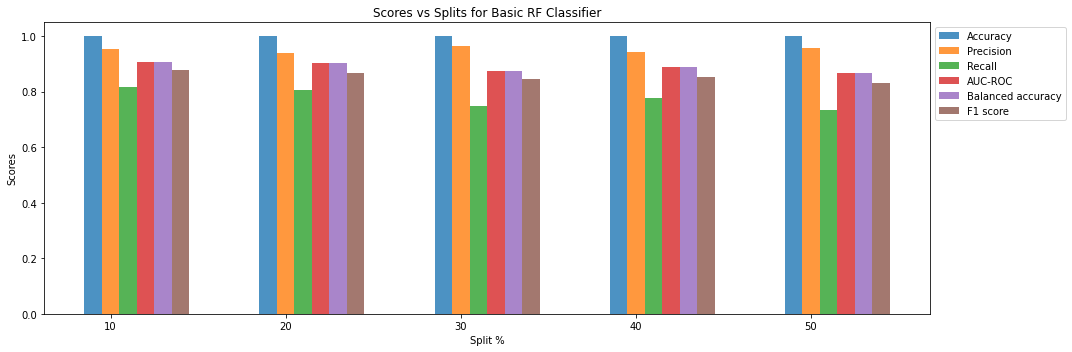

In [16]:
# plot for better visualization
x = np.arange(len(splits))
width = 0.1
opacity = 0.8
# fig, ax = plt.subplots()

# vertical bar graph
plt.figure(figsize=(15, 5))
bar1 = plt.bar(x, accuracy, width, alpha=opacity, label='Accuracy')
bar2 = plt.bar(x+width, precision, width, alpha=opacity, label='Precision')
bar3 = plt.bar(x+(2*width), recall, width, alpha=opacity, label='Recall')
bar4 = plt.bar(x+(3*width), auc, width, alpha=opacity, label='AUC-ROC')
bar5 = plt.bar(x+(4*width), balanced, width, alpha=opacity, label='Balanced accuracy')
bar5 = plt.bar(x+(5*width), f1, width, alpha=opacity, label='F1 score')

plt.xlabel('Split %')
plt.ylabel('Scores')
plt.title('Scores vs Splits for Basic RF Classifier')
plt.xticks(x+width, splits)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.tight_layout()
plt.show()

Looks like the 10% and 20% split models works better than any other, based on its balanced accuracy. We can check the ROC and PR curves for these splits.

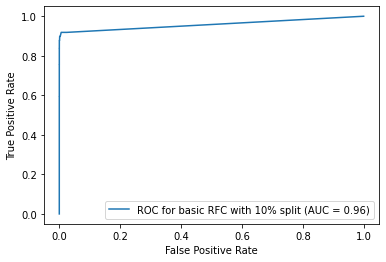

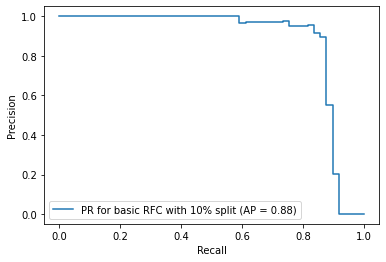

In [20]:
# plot curves
# 1using existing model of 10% split from previous code snippet
# roc curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
plot_roc_curve(models[0], X_test, Y_test, name='ROC for basic RFC with 10% split')
plt.show()
# pr curve
plot_precision_recall_curve(models[0], X_test, Y_test, name='PR for basic RFC with 10% split')
plt.show()

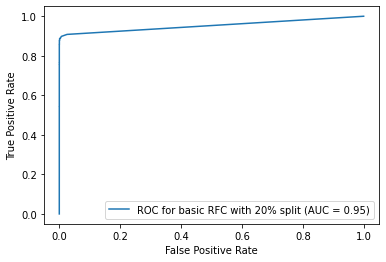

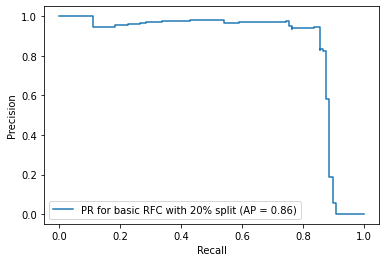

In [21]:
# using existing model of 20% split from previous code snippet
# roc curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
plot_roc_curve(models[1], X_test, Y_test, name='ROC for basic RFC with 20% split')
plt.show()
# pr curve
plot_precision_recall_curve(models[1], X_test, Y_test, name='PR for basic RFC with 20% split')
plt.show()

From results above, we observe that the basic RF classifier works best at 10% and 20% data splits for this problem. Accuracy is always highest, but can be considered a naive element for our problem and hence should not be completely relied on. Also, balanced accuracy and AUC-ROC, AUC-PR scores seem to work optimally.

### 6. Experiments using Cross-validation on dataset
We can evaluate the model by partitioning the original sample into *k* folds. 5 folds are being used here, which roughly mean 20% split. 10 folds would be roughly 10%. The train/test split thus is not of our own choosing, but we can choose the folds.

K-fold cross-validation divides the data into *k* parts, out of which 1 part is used for test and the rest *k-1* are used for training, and this process is repeated *k* times to obtain a score.

#### a. Train and test cross-validated RF model
We are using 5-fold cross-validation with this data. 

In [19]:
from sklearn.model_selection import cross_val_predict

time_cv = 0
accuracy_cv = 0
precision_cv = 0
recall_cv = 0
auc_cv = 0
f1_cv = 0
balanced_cv = 0

start = dt.datetime.now()
rf = RandomForestClassifier()
Y_cf_pred = cross_val_predict(rf, X, Y, cv=5)
print(classification_report(Y, Y_cf_pred))
accuracy_cv = accuracy_score(Y, Y_cf_pred)
precision_cv = precision_score(Y, Y_cf_pred)
recall_cv = recall_score(Y, Y_cf_pred)
auc_cv = roc_auc_score(Y, Y_cf_pred)
balanced_cv = balanced_accuracy_score(Y, Y_cf_pred)
f1_cv = f1_score(Y, Y_cf_pred)

fpr_cv, tpr_cv, _ = roc_curve(Y, Y_cf_pred)
p_cv, r_cv, _ = precision_recall_curve(Y, Y_cf_pred)
conf_mat_cv = confusion_matrix(Y, Y_cf_pred)   # for confusion matrix later
print(conf_mat_cv)
end = dt.datetime.now()

              precision    recall  f1-score   support

           0       1.00      0.80      0.89    284315
           1       0.01      0.79      0.01       492

    accuracy                           0.80    284807
   macro avg       0.50      0.80      0.45    284807
weighted avg       1.00      0.80      0.89    284807

[[227620  56695]
 [   102    390]]


#### b. Evaluate the model
We need to evaluate the cross-validated model. Again we cannot rely solely on the accuracy score. We will also look at AUC-ROC and PR, balanced accuracy and F1 score.

In [22]:
# display results
print("5-fold Cross-validated Random Forest Classifier")
print("Accuracy score = {}".format(accuracy_cv))
print("Precision score = {}".format(precision_cv))
print("Recall score = {}".format(recall_cv))
print("AUC score = {}".format(auc_cv))
print("Balanced accuracy score = {}".format(balanced_cv))
print("F1 score = {}".format(f1_cv))

5-fold Cross-validated Random Forest Classifier
Accuracy score = 0.8005772330034023
Precision score = 0.006831917316282736
Recall score = 0.7926829268292683
AUC score = 0.7966369103660789
Balanced accuracy score = 0.7966369103660789
F1 score = 0.013547076089410701


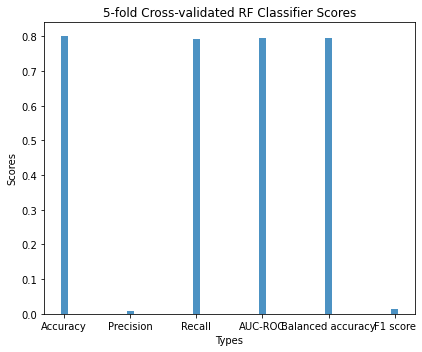

In [23]:
# plot graph
width = 0.1
opacity = 0.8

# make array
scores_cv = []
scores_cv.append(accuracy_cv)
scores_cv.append(precision_cv)
scores_cv.append(recall_cv)
scores_cv.append(auc_cv)
scores_cv.append(balanced_cv)
scores_cv.append(f1_cv)
labels_cv = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC', 'Balanced accuracy', 'F1 score']
x = np.arange(len(labels_cv))

# vertical bar graph
plt.figure(figsize=(6, 5))
bar1 = plt.bar(x, scores_cv, width, alpha=opacity)

plt.xlabel('Types')
plt.ylabel('Scores')
plt.title('5-fold Cross-validated RF Classifier Scores')
plt.xticks(x, labels_cv)

plt.tight_layout()
plt.show()

The precision seems to be slightly disappointing, but the recall is good. Even balanced accuracy is good at 79.6%. But it is still less than the 90.3% of the basic RF model with 20% data split.

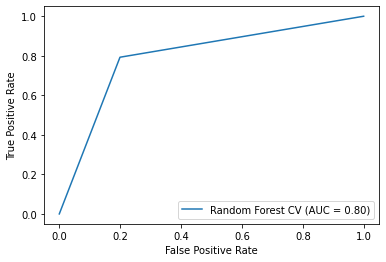

In [56]:
from sklearn.metrics import RocCurveDisplay, auc

disp = RocCurveDisplay(fpr=fpr_cv, tpr=tpr_cv, roc_auc=auc(fpr_cv, tpr_cv), estimator_name='Random Forest CV')
disp.plot()
plt.show()

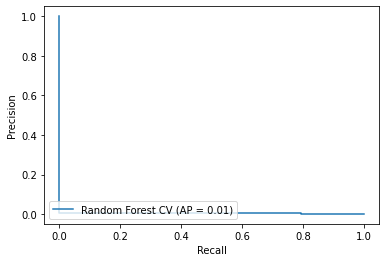

In [57]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay(precision=p_cv, recall=r_cv, average_precision=precision_cv, estimator_name='Random Forest CV')
disp.plot()
plt.show()

The AUC-ROC at 0.8 is quite good, but not that great for AUC-PR (0.01). Overall, it looks like a random 20% train/test split works much better than a 5-fold cross-validated model. We need to experiment further.

### 7. Experiments after balancing the dataset using Undersampling
Another good method to try out is balancing the dataset by performing undersampling. This means equalizing the number of non-fraudulent cases with the number of fraudulent cases, by discarding the rest, for training purpose.

In [24]:
# generate a sub-sample from existing dataset
selected_nf = valids.sample(len(frauds))
selected_f = frauds

# concatenate data into a sub-sample set
selected_nf.reset_index(drop=True, inplace=True)
selected_f.reset_index(drop=True, inplace=True)
subsample_train = pd.concat([selected_nf, selected_f])

# shuffle data
subsample_train = subsample_train.sample(frac=1).reset_index(drop=True)
subsample_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,61021.0,1.199802,0.288080,0.406009,0.627884,-0.440308,-0.872345,-0.033785,-0.051812,-0.193606,-0.104671,1.760868,0.823998,-0.207848,-0.016464,0.412956,0.630317,-0.164246,0.168234,0.016795,-0.097351,-0.226447,-0.705432,0.146230,0.486828,0.148442,0.065454,-0.028580,0.021947,1.29,0
1,147434.0,1.930606,-0.169885,-1.236238,0.273592,0.587859,0.377462,0.008901,0.070972,0.471078,-0.104083,-0.050988,1.070214,0.629085,0.194486,0.520558,-1.224756,0.653052,-2.414282,-0.935508,-0.290826,-0.157405,-0.126405,0.365230,-0.999933,-0.397616,0.372201,-0.015017,-0.073801,1.00,0
2,74408.0,-0.651771,1.358729,0.700279,-0.020250,-0.032212,-0.721050,0.365158,0.382942,-0.539096,-0.740891,-0.827294,-0.059189,0.345953,-0.159242,0.886509,0.658782,-0.022769,0.068114,0.104695,0.039080,-0.252485,-0.793731,-0.013174,-0.203836,-0.059932,0.107220,0.118107,0.030467,9.55,0
3,33775.0,-0.001517,-0.035350,1.538804,-1.661325,-0.216210,-0.842749,0.190364,-0.292265,-1.021620,0.281451,0.214730,-0.081748,1.126118,-0.724777,0.168652,0.902035,0.073108,-1.939974,-0.674173,0.087371,0.308325,1.028844,0.146892,0.422106,-1.237193,-0.661845,0.091304,0.016830,1.00,0
4,48308.0,-0.598182,1.234220,1.204061,-0.108590,0.000779,-0.686514,0.561331,0.112565,-0.392239,-0.019475,1.426386,0.365064,-0.443453,-0.208621,0.259864,0.580035,-0.224456,0.398816,0.172540,0.218102,-0.248639,-0.637678,-0.016948,0.261262,-0.156451,0.060746,0.345047,0.146577,0.89,0


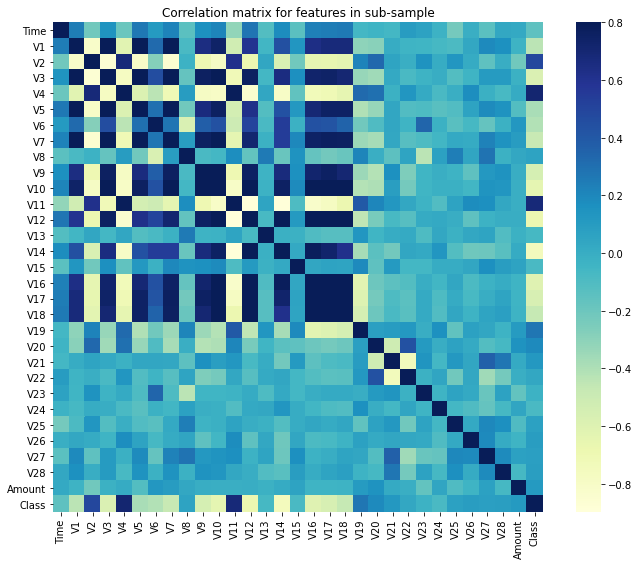

In [25]:
plt.figure(figsize=(12, 9))
plt.title('Correlation matrix for features in sub-sample')
# plot the matrix as a heatmap
sns.heatmap(subsample_train.corr(), vmax=0.8, cmap='YlGnBu', square=True)
plt.show()

There is a sudden shift in the correlation matrix once we got rid of a lot of samples. This means there is a lot of dependency between features in such a small dataset, and there is very low chance of discarding variables if needed. We now check how Random Forest works on undersampled data.

In [28]:
# separate features and output of the dataset
X_s = subsample_train.drop(labels='Class', axis=1)   # the features
Y_s = subsample_train.loc[:, 'Class']    # the classification

# arrays for comparing/plotting results later
accuracy_us = []
precision_us = []
recall_us = []
auc_us = []
balanced_us = []
f1_us = []
splits_us = []
models_us = []
roc_us = []
pr_us = []
conf_mat_us = []

# for each split percent
for split in range(10, 21, 10):
    splits_us.append(split)
    X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y_s, test_size=split/100, random_state=42, stratify=Y_s)
    # train
    rfc_model_us = RandomForestClassifier()
    rfc_model_us.fit(X_s_train, Y_s_train)
    models_us.append(rfc_model_us)
    # test
    Y_s_pred = rfc_model_us.predict(X_s_test)
    print("Undersampled RF with split = {}".format(split))
    print(classification_report(Y_s_test, Y_s_pred))
    fpr_us, tpr_us, _ = roc_curve(Y_s_test, Y_s_pred)
    roc_us.append([tpr_us, fpr_us])  # for roc curve
    p_us, r_us, _ = precision_recall_curve(Y_s_test, Y_s_pred)
    pr_us.append([p_us, r_us])   # for pr curve
    cfm_us = confusion_matrix(Y_s_test, Y_s_pred)
    print(cfm_us)
    print("----------")
    conf_mat_us.append(cfm_us)   # for confusion matrix later
    # score
    accuracy_us.append(accuracy_score(Y_s_test, Y_s_pred))
    precision_us.append(precision_score(Y_s_test, Y_s_pred))
    recall_us.append(recall_score(Y_s_test, Y_s_pred))
    auc_us.append(roc_auc_score(Y_s_test, Y_s_pred))
    balanced_us.append(balanced_accuracy_score(Y_s_test, Y_s_pred))
    f1_us.append(f1_score(Y_s_test, Y_s_pred))

Undersampled RF with split = 10
              precision    recall  f1-score   support

           0       0.85      0.94      0.90        50
           1       0.93      0.84      0.88        49

    accuracy                           0.89        99
   macro avg       0.89      0.89      0.89        99
weighted avg       0.89      0.89      0.89        99

[[47  3]
 [ 8 41]]
----------
Undersampled RF with split = 20
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        99
           1       0.96      0.92      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

[[95  4]
 [ 8 90]]
----------


In [29]:
# display results
for i in range(len(splits_us)):
    print("----------")
    print("Random Forest Classifier with Undersampling at {}% split:".format(splits_us[i]))
    print("Accuracy score = {}".format(accuracy_us[i]))
    print("Precision score = {}".format(precision_us[i]))
    print("Recall score = {}".format(recall_us[i]))
    print("AUC score = {}".format(auc_us[i]))
    print("Balanced accuracy score = {}".format(balanced_us[i]))
    print("F1 score = {}".format(f1_us[i]))

----------
Random Forest Classifier with Undersampling at 10% split:
Accuracy score = 0.8888888888888888
Precision score = 0.9318181818181818
Recall score = 0.8367346938775511
AUC score = 0.8883673469387754
Balanced accuracy score = 0.8883673469387755
F1 score = 0.8817204301075268
----------
Random Forest Classifier with Undersampling at 20% split:
Accuracy score = 0.9390862944162437
Precision score = 0.9574468085106383
Recall score = 0.9183673469387755
AUC score = 0.9389816532673675
Balanced accuracy score = 0.9389816532673676
F1 score = 0.9375000000000001


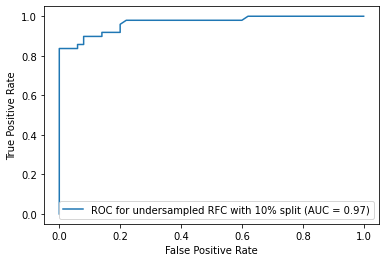

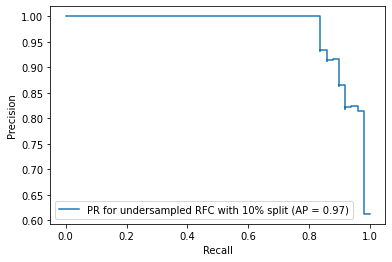

In [30]:
# plot curves
# using existing model of 10% split from previous code snippet
X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y_s, test_size=0.1, random_state=42, stratify=Y_s)
plot_roc_curve(models_us[0], X_s_test, Y_s_test, name='ROC for undersampled RFC with 10% split')
plt.show()
plot_precision_recall_curve(models_us[0], X_s_test, Y_s_test, name='PR for undersampled RFC with 10% split')
plt.show()

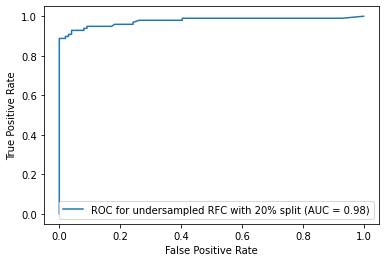

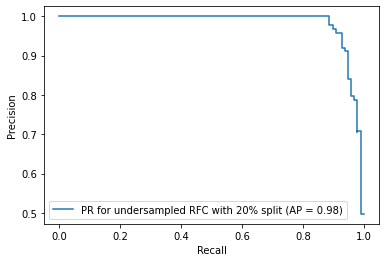

In [31]:
# using existing model of 20% split from previous code snippet
X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y_s, test_size=0.2, random_state=42, stratify=Y_s)
plot_roc_curve(models_us[1], X_s_test, Y_s_test, name='ROC for undersampled RFC with 20% split')
plt.show()
plot_precision_recall_curve(models_us[1], X_s_test, Y_s_test, name='PR for undersampled RFC with 20% split')
plt.show()

Looks like the basic Random Forest classifier works very well with the undersampled dataset. Looking at the scores of the model with 20% split, we see some good values indeed. Balanced accuracy of 93%, and both AUC-ROC and AUC-PR at 0.98 look amazing. But this also means that the model hasn't been trained enough and might fail at random points. Thus its reliability is questionable.

### 8. Using AdaBoost with Random Forest classifier on the dataset
We now look at how AdaBoost can be helpful with our original Random Forest model. Note that AdaBoost is a boosting technique, while Random Forest is a bagging technique of the ensemble learning. Boosting normally works with sequential models (like Decision Trees), while Random Forest works more in parallel. We expect to see competing results. We have stuck to 10% and 20% train/test splits.

#### a. At 20% train/test split

In [32]:
# imports again
from sklearn.ensemble import AdaBoostClassifier

# saving adaboost models
models_ab = []

X_ar_train, X_ar_test, Y_ar_train, Y_ar_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
adb_rf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=100)
adb_rf.fit(X_ar_train, Y_ar_train)
models_ab.append(adb_rf)    # save for later

Y_ar_pred = adb_rf.predict(X_ar_test)
confusion_matrix(Y_ar_test, Y_ar_pred)

array([[56859,     5],
       [   18,    80]])

In [33]:
# scores
accuracy_ar = accuracy_score(Y_ar_test, Y_ar_pred)
precision_ar = precision_score(Y_ar_test, Y_ar_pred)
recall_ar = recall_score(Y_ar_test, Y_ar_pred)
auc_ar = roc_auc_score(Y_ar_test, Y_ar_pred)
balanced_ar = balanced_accuracy_score(Y_ar_test, Y_ar_pred)
f1_ar = f1_score(Y_ar_test, Y_ar_pred)

# display results
print("Random Forest Classifier with AdaBoost at 20% split")
print("Accuracy score = {}".format(accuracy_ar))
print("Precision score = {}".format(precision_ar))
print("Recall score = {}".format(recall_ar))
print("AUC score = {}".format(auc_ar))
print("Balanced accuracy score = {}".format(balanced_ar))
print("F1 score = {}".format(f1_ar))

Random Forest Classifier with AdaBoost at 20% split
Accuracy score = 0.9995962220427653
Precision score = 0.9411764705882353
Recall score = 0.8163265306122449
AUC score = 0.9081193007591333
Balanced accuracy score = 0.9081193007591332
F1 score = 0.8743169398907105


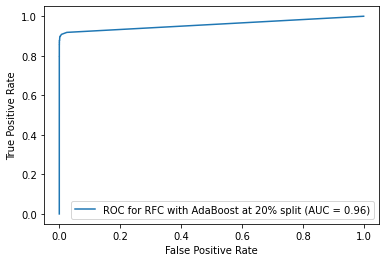

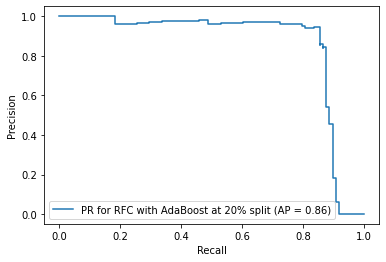

In [34]:
# plots
plot_roc_curve(models_ab[0], X_ar_test, Y_ar_test, name='ROC for RFC with AdaBoost at 20% split')
plt.show()
plot_precision_recall_curve(models_ab[0], X_ar_test, Y_ar_test, name='PR for RFC with AdaBoost at 20% split')
plt.show()

We see no change in the scores of the basic Random Forest model after applying AdaBoost with 20%. The accuracies of both before and after are at 99.9%. Same goes for AUC-ROC at roughly 0.95, AUC-PR at 0.86 and balanced accuracy at roughly 90.3%

#### b. At 10% train/test split

In [35]:
# similarly for 10% split
X_ar_train_1, X_ar_test_1, Y_ar_train_1, Y_ar_test_1 = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
adb_rf_1 = AdaBoostClassifier(RandomForestClassifier(), n_estimators=100)
adb_rf_1.fit(X_ar_train_1, Y_ar_train_1)
models_ab.append(adb_rf_1)    # save for later

Y_ar_pred_1 = adb_rf_1.predict(X_ar_test_1)
confusion_matrix(Y_ar_test_1, Y_ar_pred_1)

array([[28430,     2],
       [   10,    39]])

In [36]:
# scores
accuracy_ar_1 = accuracy_score(Y_ar_test_1, Y_ar_pred_1)
precision_ar_1 = precision_score(Y_ar_test_1, Y_ar_pred_1)
recall_ar_1 = recall_score(Y_ar_test_1, Y_ar_pred_1)
auc_ar_1 = roc_auc_score(Y_ar_test_1, Y_ar_pred_1)
balanced_ar_1 = balanced_accuracy_score(Y_ar_test_1, Y_ar_pred_1)
f1_ar_1 = f1_score(Y_ar_test_1, Y_ar_pred_1)

# display results
print("Random Forest Classifier with AdaBoost at 10% split")
print("Accuracy score = {}".format(accuracy_ar_1))
print("Precision score = {}".format(precision_ar_1))
print("Recall score = {}".format(recall_ar_1))
print("AUC score = {}".format(auc_ar_1))
print("Balanced accuracy score = {}".format(balanced_ar_1))
print("F1 score = {}".format(f1_ar_1))

Random Forest Classifier with AdaBoost at 10% split
Accuracy score = 0.9995786664794073
Precision score = 0.9512195121951219
Recall score = 0.7959183673469388
AUC score = 0.897924012035878
Balanced accuracy score = 0.897924012035878
F1 score = 0.8666666666666666


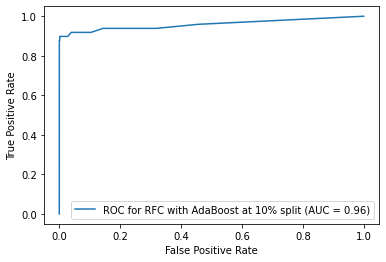

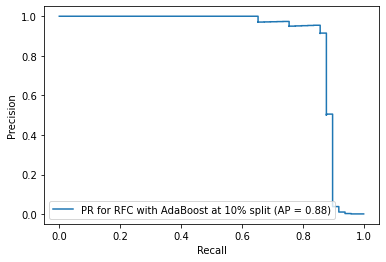

In [37]:
# plots
plot_roc_curve(models_ab[1], X_ar_test_1, Y_ar_test_1, name='ROC for RFC with AdaBoost at 10% split')
plt.show()
plot_precision_recall_curve(models_ab[1], X_ar_test_1, Y_ar_test_1, name='PR for RFC with AdaBoost at 10% split')
plt.show()

Similar to the 20% split, there is negligible change in the scores of the basic Random Forest model after applying AdaBoost with 10%. The accuracies of both before and after are at 99.9%. Same goes for AUC-ROC at 0.96 and AUC-PR at 0.88. Only balanced accuracy has a slight change from 90.8% to 89.7%

### 9. Using AdaBoost with Decision Tree classifier on the dataset
As we know that AdaBoost, or boosting in general works well with sequential models like Decision Trees, we also try implementing this method.

#### a. At 20% train/test split

In [38]:
# more imports
from sklearn.tree import DecisionTreeClassifier

X_ad_train, X_ad_test, Y_ad_train, Y_ad_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
adb_dt = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100)
adb_dt.fit(X_ad_train, Y_ad_train)
models_ab.append(adb_dt)    # save for later

Y_ad_pred = adb_dt.predict(X_ad_test)
confusion_matrix(Y_ad_test, Y_ad_pred)

array([[56837,    27],
       [   26,    72]])

In [39]:
# scores
accuracy_ad = accuracy_score(Y_ad_test, Y_ad_pred)
precision_ad = precision_score(Y_ad_test, Y_ad_pred)
recall_ad = recall_score(Y_ad_test, Y_ad_pred)
auc_ad = roc_auc_score(Y_ad_test, Y_ad_pred)
balanced_ad = balanced_accuracy_score(Y_ad_test, Y_ad_pred)
f1_ad = f1_score(Y_ad_test, Y_ad_pred)

# display results
print("Decision Tree with AdaBoost at 20% split")
print("Accuracy score = {}".format(accuracy_ad))
print("Precision score = {}".format(precision_ad))
print("Recall score = {}".format(recall_ad))
print("AUC score = {}".format(auc_ad))
print("Balanced accuracy score = {}".format(balanced_ad))
print("F1 score = {}".format(f1_ad))

Decision Tree with AdaBoost at 20% split
Accuracy score = 0.9990695551420246
Precision score = 0.7272727272727273
Recall score = 0.7346938775510204
AUC score = 0.867109530221768
Balanced accuracy score = 0.867109530221768
F1 score = 0.730964467005076


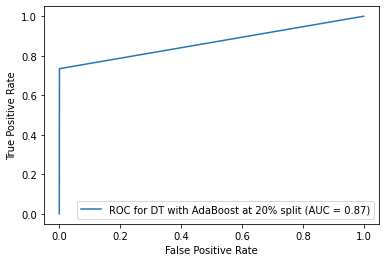

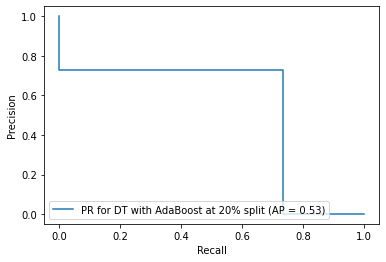

In [40]:
# plots
plot_roc_curve(models_ab[2], X_ad_test, Y_ad_test, name='ROC for DT with AdaBoost at 20% split')
plt.show()
plot_precision_recall_curve(models_ab[2], X_ad_test, Y_ad_test, name='PR for DT with AdaBoost at 20% split')
plt.show()

#### b. At 10% train/test split

In [41]:
X_ad_train_1, X_ad_test_1, Y_ad_train_1, Y_ad_test_1 = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
adb_dt = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100)
adb_dt.fit(X_ad_train_1, Y_ad_train_1)
models_ab.append(adb_dt)    # save for later

Y_ad_pred_1 = adb_dt.predict(X_ad_test_1)
confusion_matrix(Y_ad_test_1, Y_ad_pred_1)

array([[28416,    16],
       [   12,    37]])

In [58]:
# scores
accuracy_ad_1 = accuracy_score(Y_ad_test_1, Y_ad_pred_1)
precision_ad_1 = precision_score(Y_ad_test_1, Y_ad_pred_1)
recall_ad_1 = recall_score(Y_ad_test_1, Y_ad_pred_1)
auc_ad_1 = roc_auc_score(Y_ad_test_1, Y_ad_pred_1)
balanced_ad_1 = balanced_accuracy_score(Y_ad_test_1, Y_ad_pred_1)
f1_ad_1 = f1_score(Y_ad_test_1, Y_ad_pred_1)

# display results
print("Decision Tree with AdaBoost at 10% split")
print("Accuracy score = {}".format(accuracy_ad_1))
print("Precision score = {}".format(precision_ad_1))
print("Recall score = {}".format(recall_ad_1))
print("AUC score = {}".format(auc_ad_1))
print("Balanced accuracy score = {}".format(balanced_ad_1))
print("F1 score = {}".format(f1_ad_1))

Decision Tree with AdaBoost at 10% split
Accuracy score = 0.9990168884519505
Precision score = 0.6981132075471698
Recall score = 0.7551020408163265
AUC score = 0.8772696473074317
Balanced accuracy score = 0.8772696473074317
F1 score = 0.7254901960784315


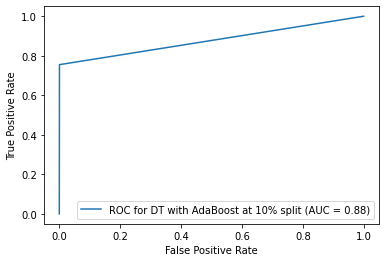

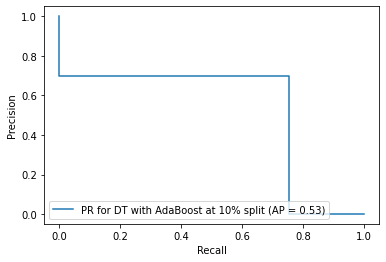

In [43]:
# plots
plot_roc_curve(models_ab[3], X_ad_test_1, Y_ad_test_1, name='ROC for DT with AdaBoost at 10% split')
plt.show()
plot_precision_recall_curve(models_ab[3], X_ad_test_1, Y_ad_test_1, name='PR for DT with AdaBoost at 10% split')
plt.show()

There is a sharp decrease in the scores from a basic or a boosted Random Forest model to a boosted Decision Tree. We can safely say that this approach is not suitable for this problem.

### 10. Analysis of results

We need to analyze the all results we have obtained in the notebook above.

In [59]:
# f: final
f_acc = [accuracy[0], accuracy_cv, accuracy_us[1], accuracy_ar, accuracy_ad]
f_pre = [precision[0], precision_cv, precision_us[1], precision_ar, precision_ad]
f_rec = [recall[0], recall_cv, recall_us[1], recall_ar, recall_ad]
f_auc = [0.95, 0.8, 0.98, 0.96, 0.87]  # obtained from curves
f_ap = [0.86, 0.01, 0.98, 0.86, 0.53]   # obtained from curves
f_bal = [balanced[0], balanced_cv, balanced_us[1], balanced_ar, balanced_ad]
f_f1 = [f1[0], f1_cv, f1_us[1], f1_ar, f1_ad]
f_names = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC', 'AUC-PR', 'Balanced accuracy', 'F1 score']
f_exp = ['Basic RFC', 'CV 5-fold', 'Undersampled', 'RF AdaBoost', 'AdaBoost DT']

print(f_exp)
print("Accuracy: {}".format(f_acc))
print("Precision: {}".format(f_pre))
print("Recall: {}".format(f_rec))
print("AUC-ROC: {}".format(f_auc))
print("AUC-PR: {}".format(f_ap))
print("Balanced accuracy: {}".format(f_bal))
print("F1: {}".format(f_f1))

['Basic RFC', 'CV 5-fold', 'Undersampled', 'RF AdaBoost', 'AdaBoost DT']
Accuracy: [0.9996137776061234, 0.8005772330034023, 0.9390862944162437, 0.9995962220427653, 0.9990695551420246]
Precision: [0.9523809523809523, 0.006831917316282736, 0.9574468085106383, 0.9411764705882353, 0.7272727272727273]
Recall: [0.8163265306122449, 0.7926829268292683, 0.9183673469387755, 0.8163265306122449, 0.7346938775510204]
AUC-ROC: [0.95, 0.8, 0.98, 0.96, 0.87]
AUC-PR: [0.86, 0.01, 0.98, 0.86, 0.53]
Balanced accuracy: [0.908128093668531, 0.7966369103660789, 0.9389816532673676, 0.9081193007591332, 0.867109530221768]
F1: [0.8791208791208791, 0.013547076089410701, 0.9375000000000001, 0.8743169398907105, 0.730964467005076]


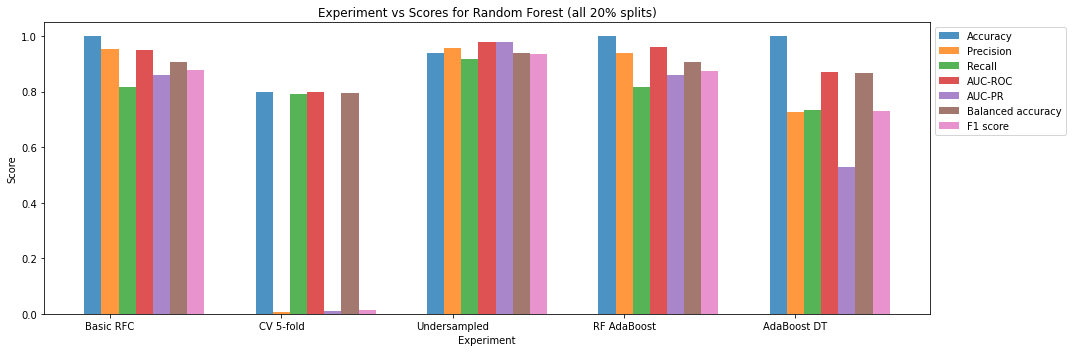

In [60]:
# plot for better visualization
x = np.arange(len(f_exp))
width = 0.1
opacity = 0.8

# vertical bar graph
plt.figure(figsize=(15, 5))
bar1 = plt.bar(x, f_acc, width, alpha=opacity, label=f_names[0])
bar2 = plt.bar(x+width, f_pre, width, alpha=opacity, label=f_names[1])
bar3 = plt.bar(x+(2*width), f_rec, width, alpha=opacity, label=f_names[2])
bar4 = plt.bar(x+(3*width), f_auc, width, alpha=opacity, label=f_names[3])
bar5 = plt.bar(x+(4*width), f_ap, width, alpha=opacity, label=f_names[4])
bar6 = plt.bar(x+(5*width), f_bal, width, alpha=opacity, label=f_names[5])
bar7 = plt.bar(x+(6*width), f_f1, width, alpha=opacity, label=f_names[6])

plt.xlabel('Experiment')
plt.ylabel('Score')
plt.title('Experiment vs Scores for Random Forest (all 20% splits)')
plt.xticks(x+width, f_exp)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.tight_layout()
plt.show()

From all the results consolidated above, the ones with 20% train/test split of data made more sense than any other percent splits. Thus we plotted the chart above to better understand what is happening at 20% split with each type of model.

It is evident that for this problem, both the basic Random Forest and the boosted Random Forest seem to work optimally when data is split at 80:20.